# Models without tweets features

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
from sklearn import model_selection, linear_model
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

# visualization library
import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":24,"axes.titlesize":24,"axes.labelsize":24})   

# import matplotlib and allow it to plot inline
import matplotlib.pyplot as plt
%matplotlib inline

# seaborn can generate several warnings, we ignore them
import warnings 
warnings.filterwarnings("ignore")

import missingno as msno
import math

### Load, join and clean datasets

In [50]:
#targets:
#    0: porn
#    1: propaganda
#    2: spam
#    3: fake followers
#    4: genuine accounts

porn = pd.read_csv('data/porn/users.csv', encoding='utf-8-sig')
porn['target'] = 0

propaganda = pd.read_csv('data/propaganda/users.csv', encoding='utf-8-sig')
propaganda['target'] = 1

spam = pd.read_csv('data/spam/users.csv', encoding='utf-8-sig')
spam['target'] = 2

fake_followers = pd.read_csv('data/fake_followers/users.csv', encoding='utf-8-sig')
fake_followers['target'] = 3
chosen_idx = np.random.choice(8825, replace=False, size=5000)
fake_followers = fake_followers.iloc[chosen_idx]

genuine = pd.read_csv('data/genuine/users.csv', encoding='utf-8-sig')
genuine['target'] = 4

frames = [porn, propaganda, spam, fake_followers, genuine]
users = pd.concat(frames, ignore_index=True)

## Visualize missing values

### Full

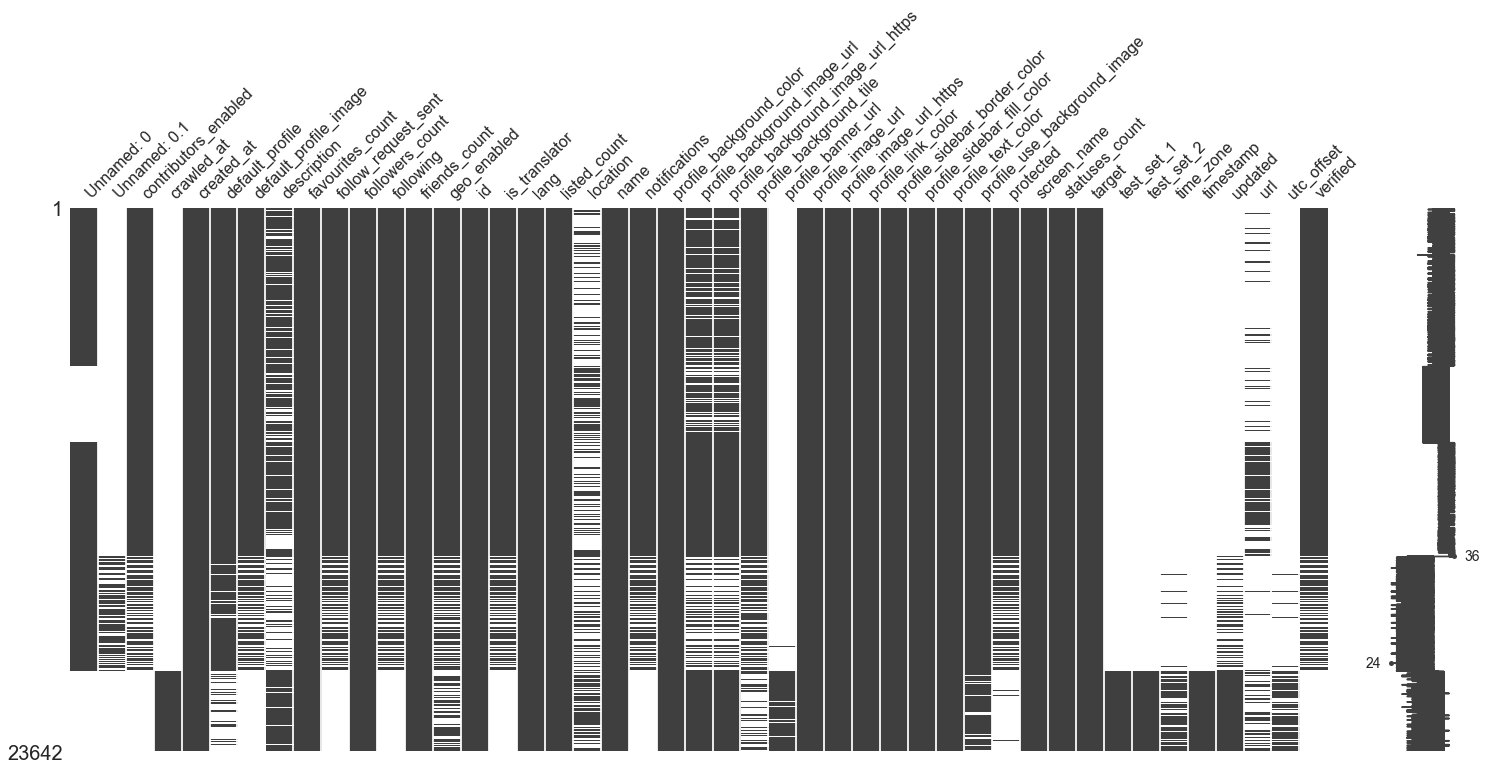

In [51]:
msno.matrix(users)

### Porn Bots

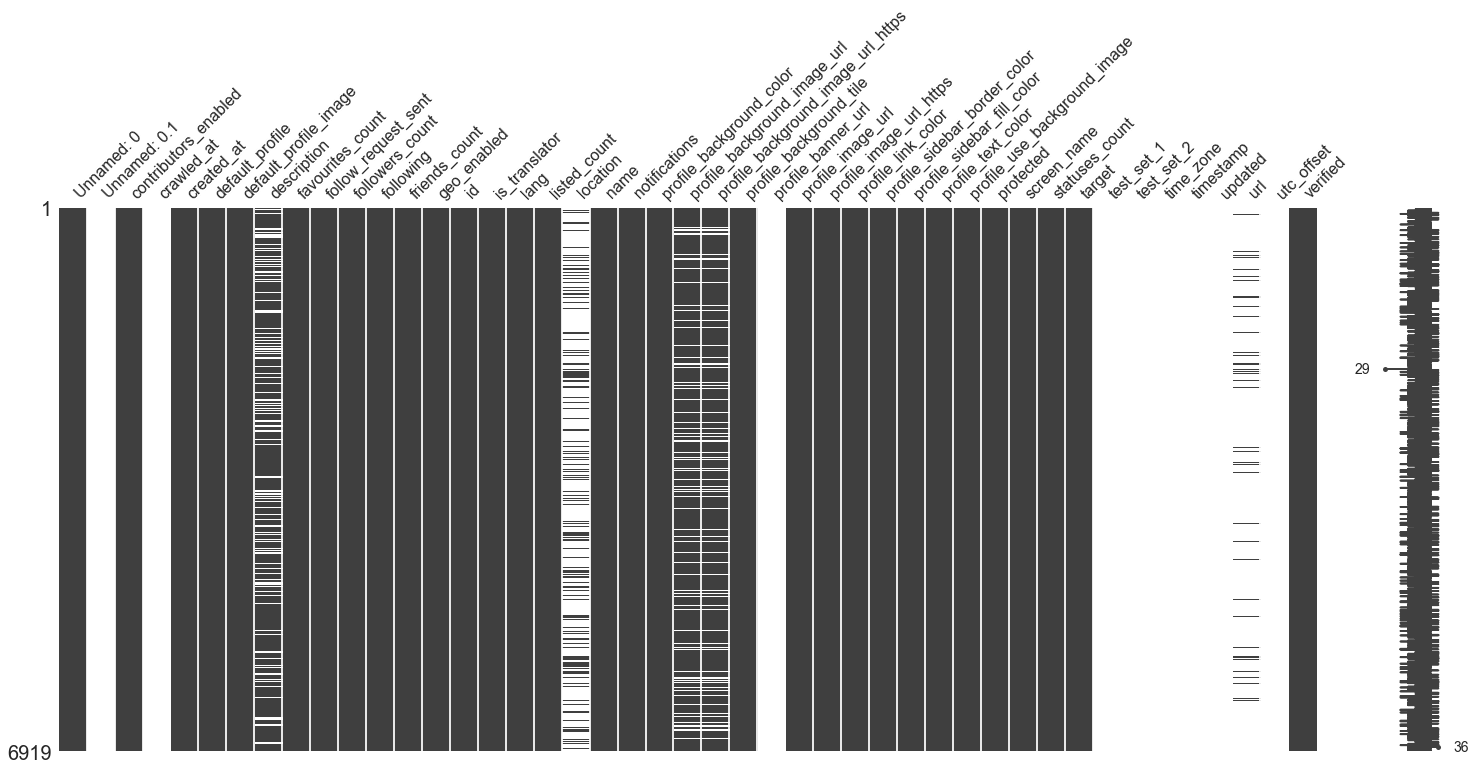

In [52]:
msno.matrix(users[users.target==0])

### Propaganda Bots

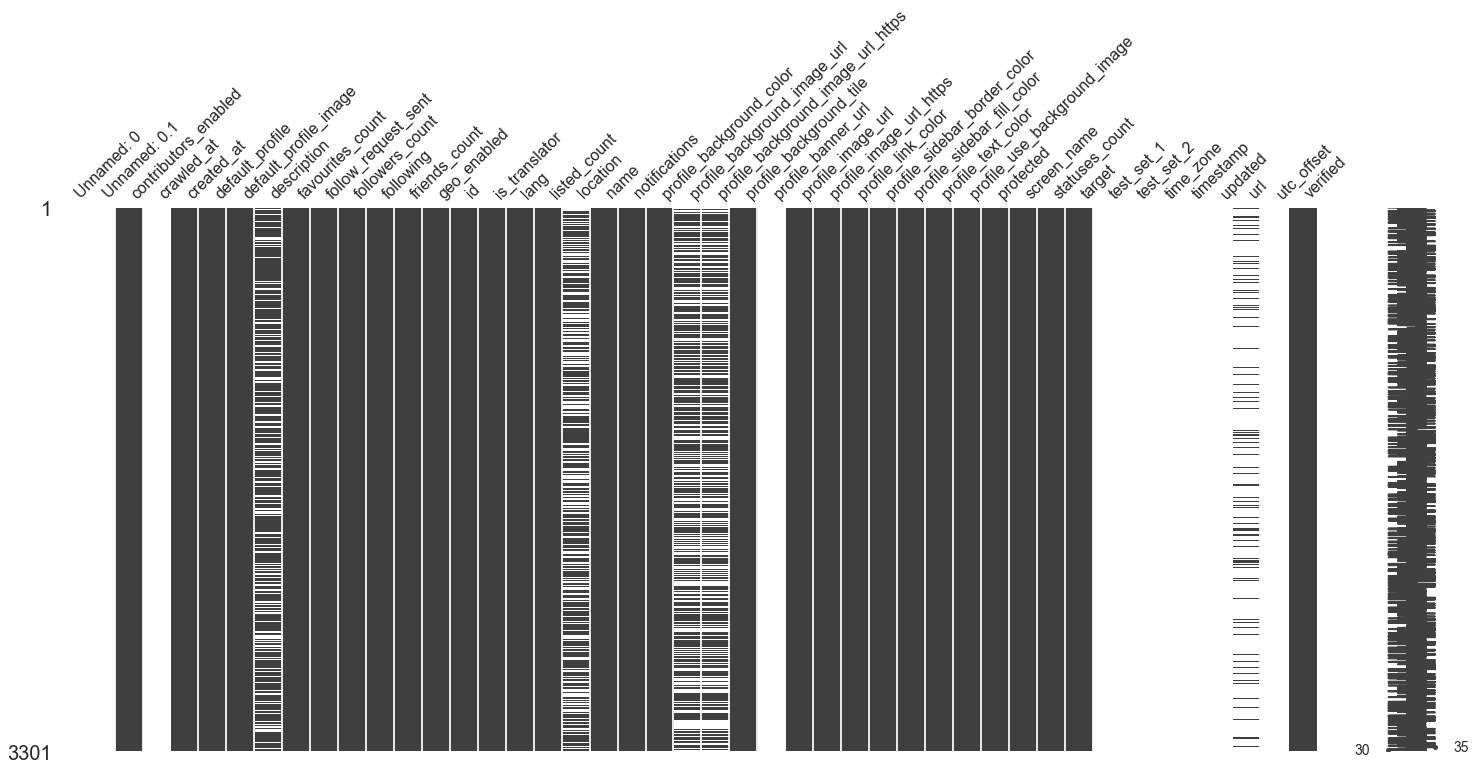

In [53]:
msno.matrix(users[users.target==1])

### Spam Bots

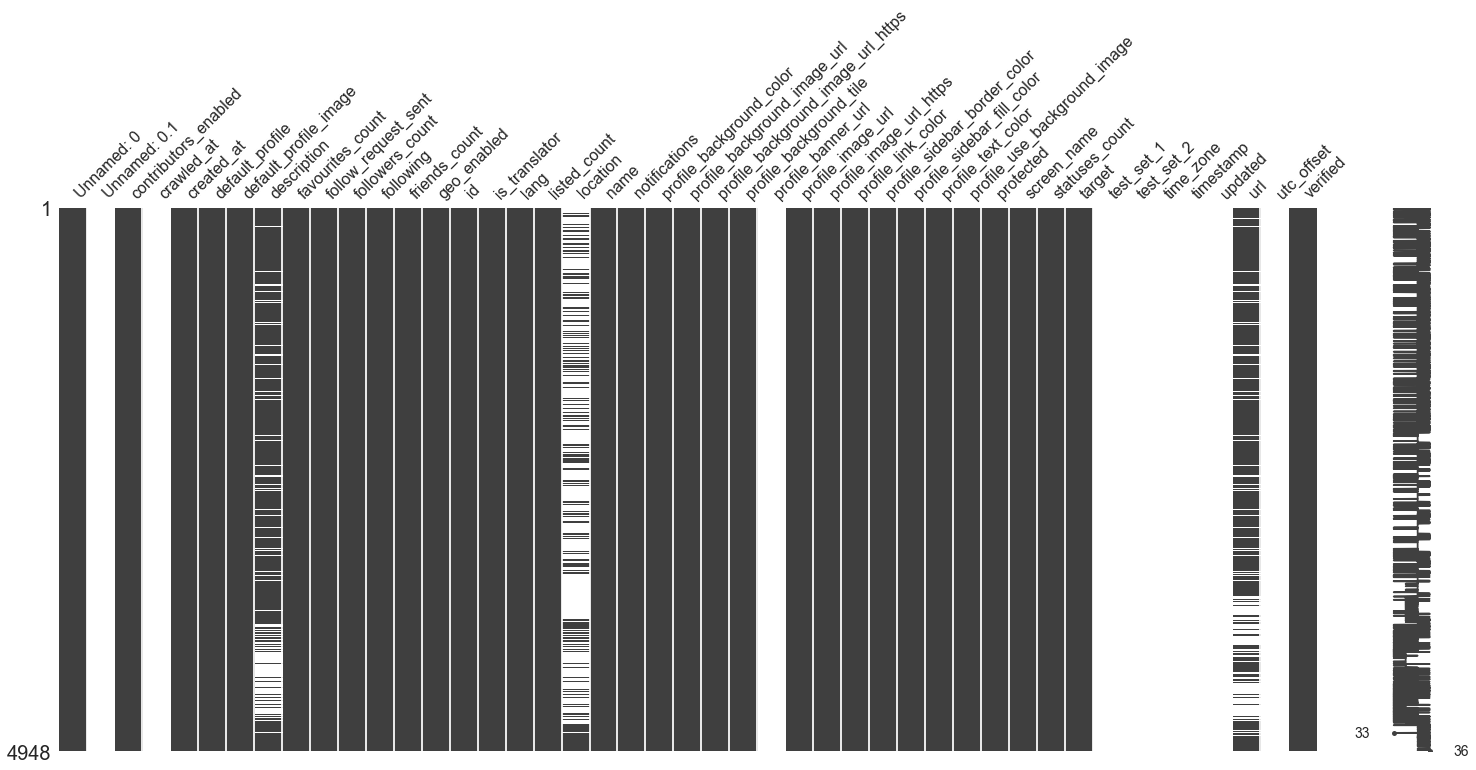

In [54]:
msno.matrix(users[users.target==2])

### Fake Followers

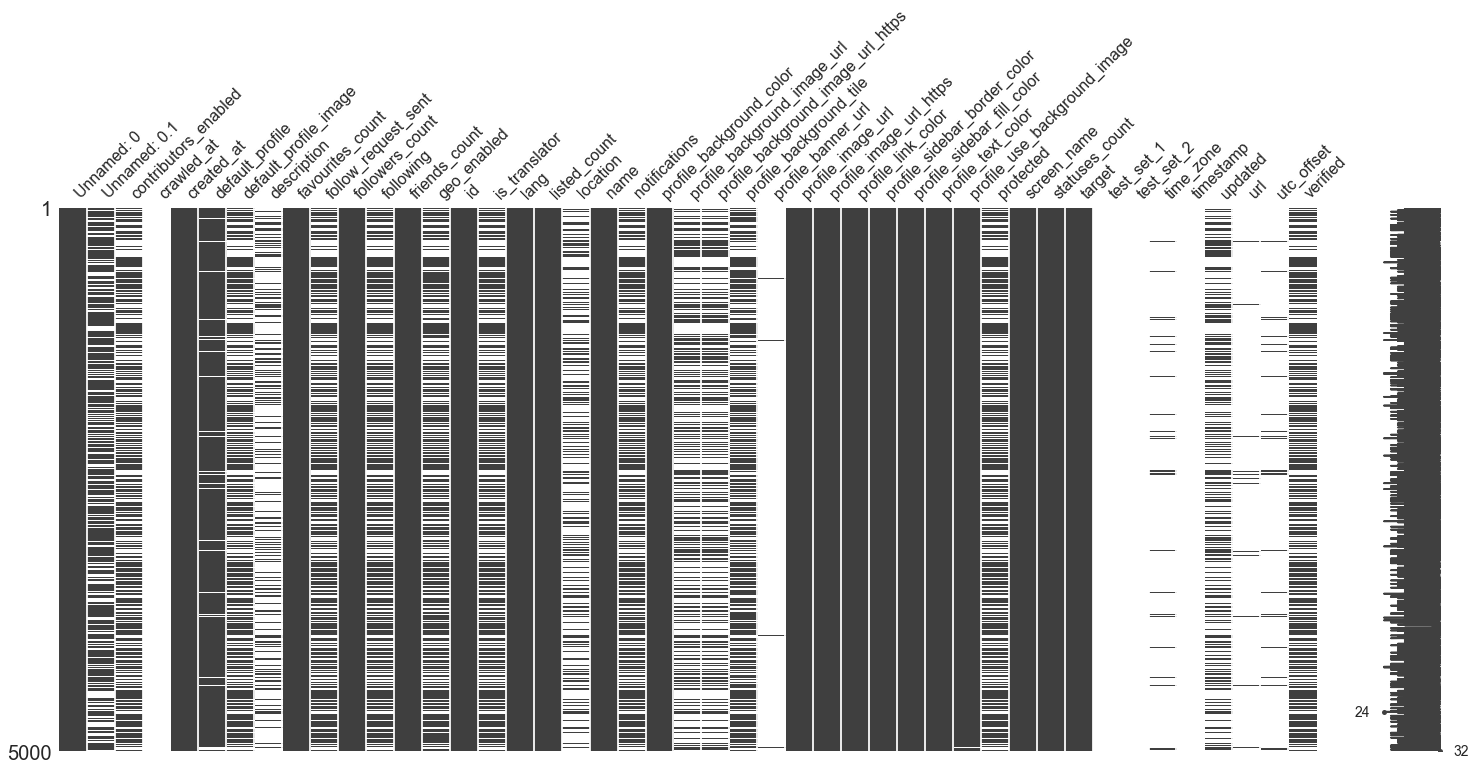

In [55]:
msno.matrix(users[users.target==3])

### Genuine Accounts

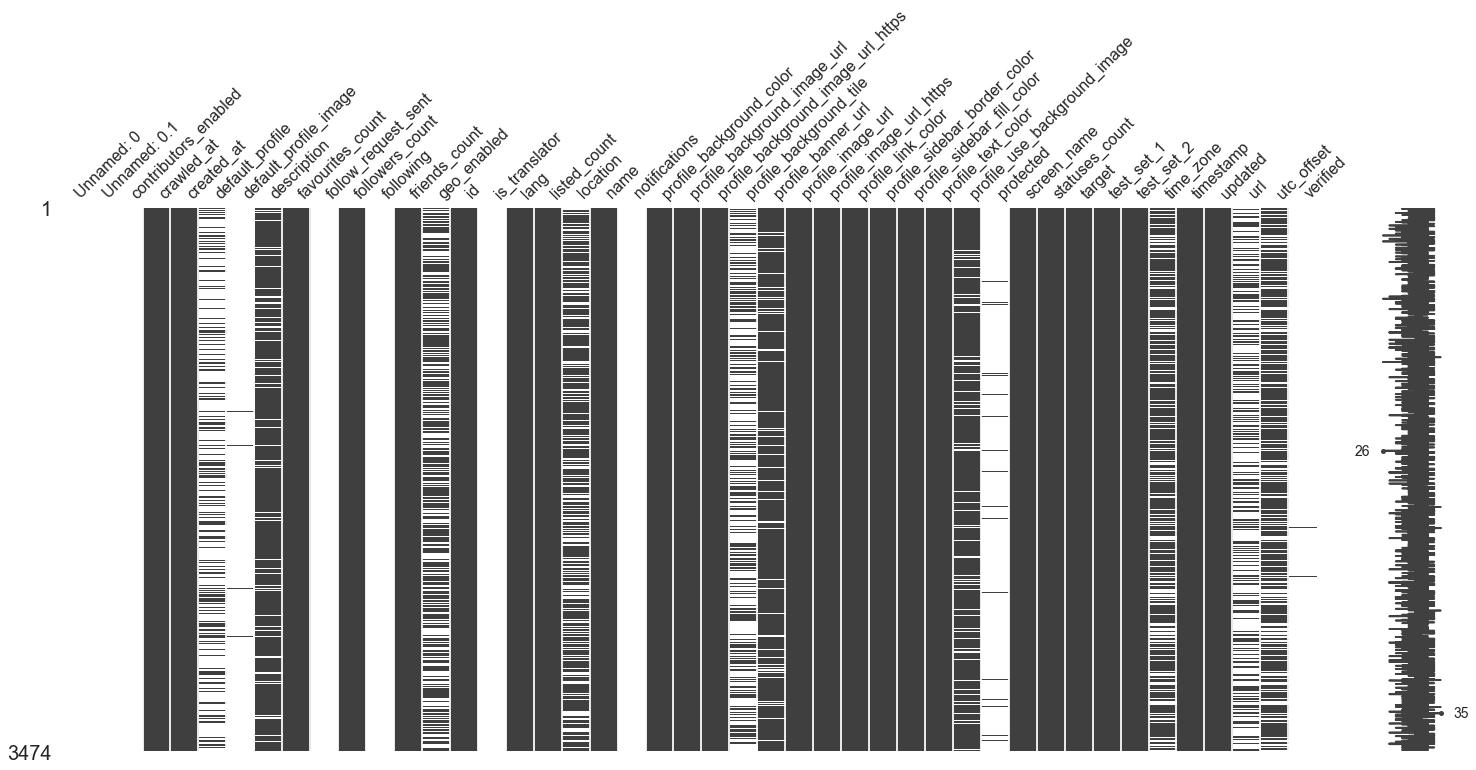

In [56]:
msno.matrix(users[users.target==4])

### remove attributes with a lot of missing values 

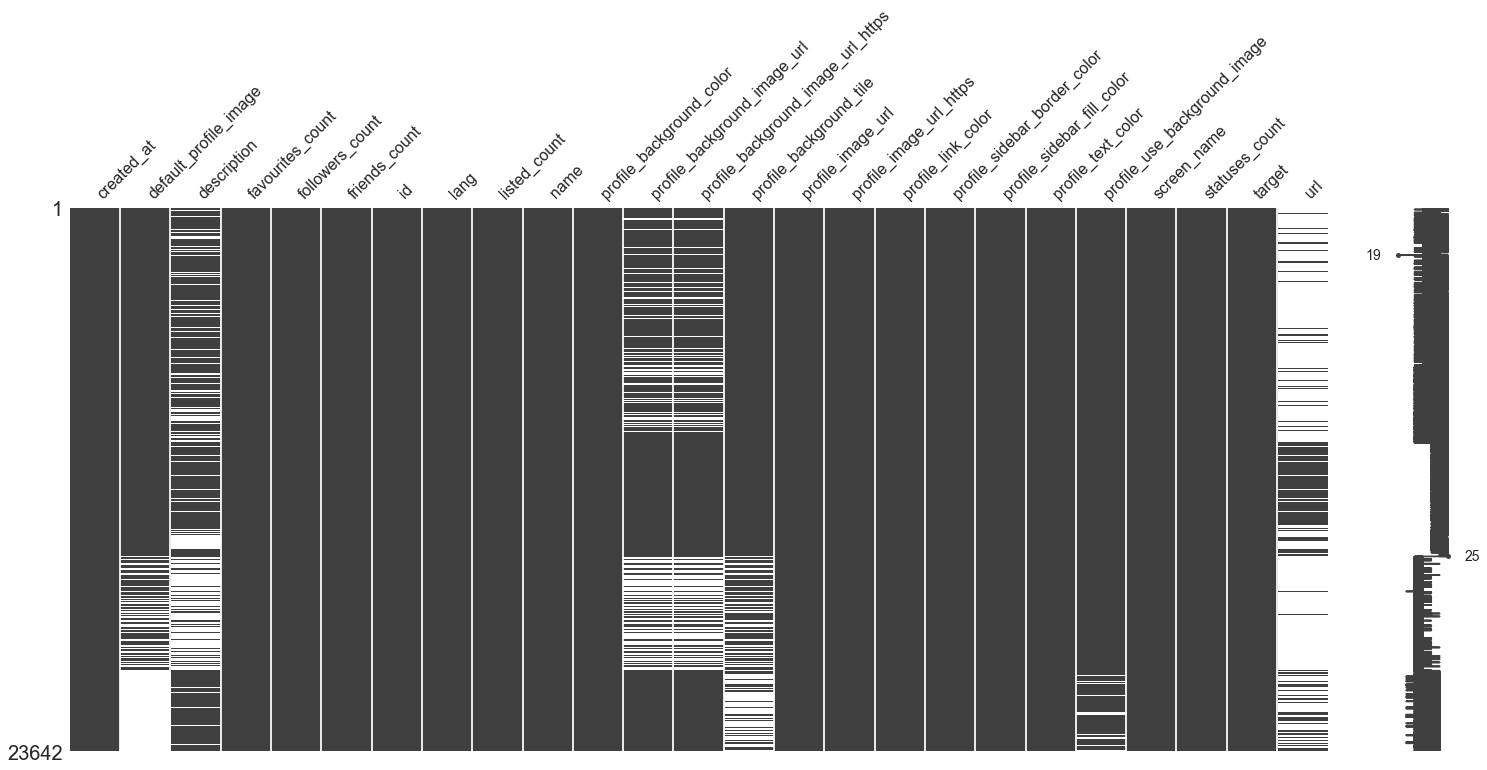

In [57]:
users = users.drop(columns=['default_profile', 'location', 'verified', 'Unnamed: 0', 'Unnamed: 0.1', 'contributors_enabled', 'crawled_at', 'follow_request_sent', 'following', 'geo_enabled', 'is_translator', 'notifications', 'profile_banner_url', 'test_set_1', 'test_set_2', 'time_zone', 'timestamp', 'updated', 'utc_offset', 'protected'], axis=1)
msno.matrix(users)

### Remove useless attributes

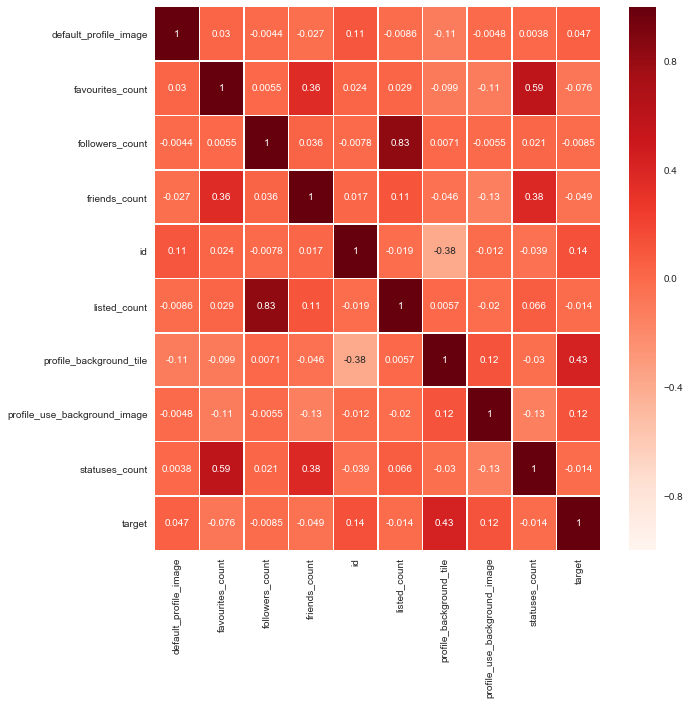

In [58]:
fig, ax = plt.subplots(figsize=(10,10))
cov=users.corr(method='pearson')
sns.heatmap(cov,annot=True,cmap="Reds",linewidths=.5, ax=ax)

In [59]:
users = users.drop(columns=['id', 'screen_name'], axis=1)

### Fill missing fields

Distribution of missing values

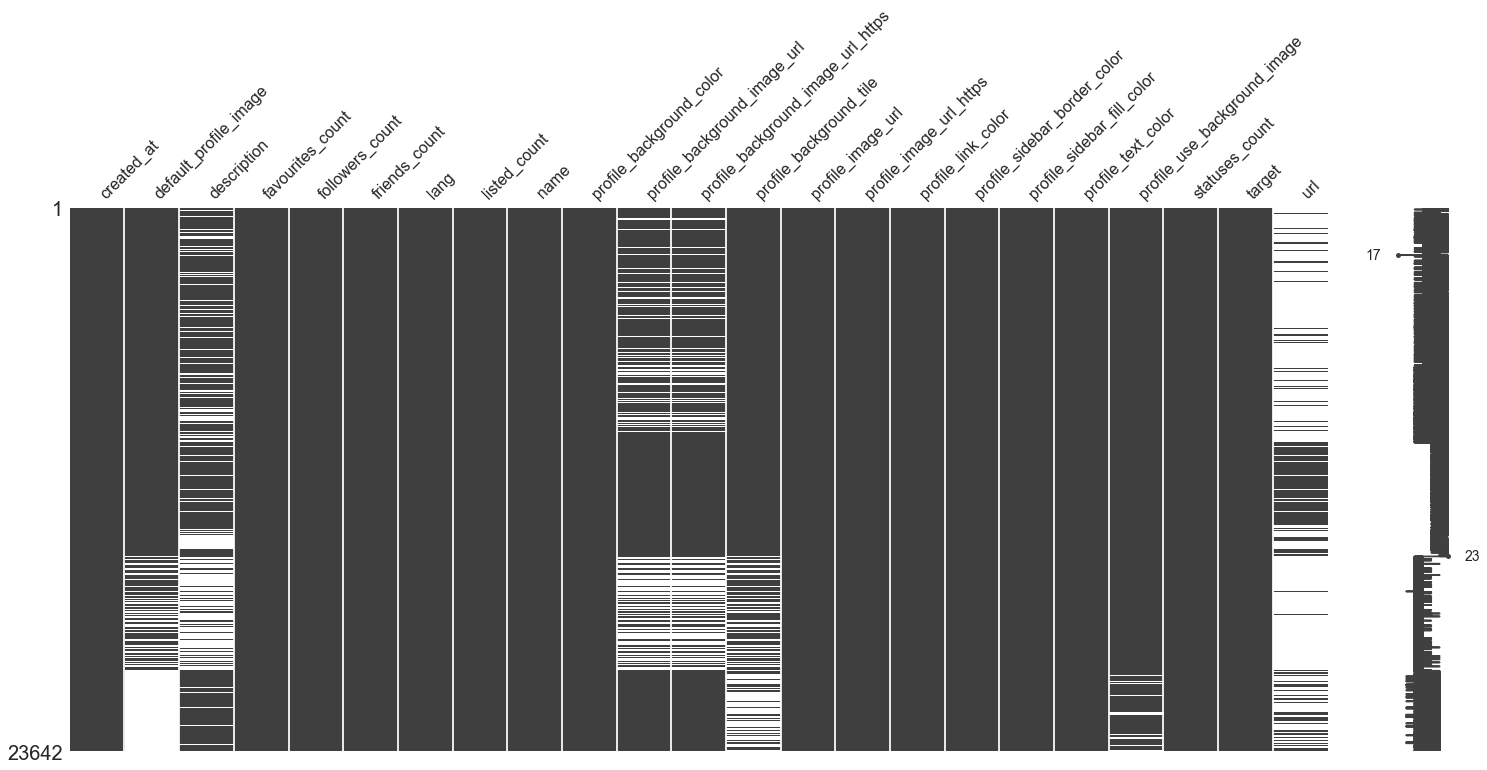

In [60]:
msno.matrix(users)

Fill missing values

In [61]:
users['default_profile_image'].describe()

count    18247.000000
mean         0.045542
std          0.208495
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: default_profile_image, dtype: float64

In [62]:
print(users[users.target == 0]['default_profile_image'].isnull().values.any())
print(users[users.target == 1]['default_profile_image'].isnull().values.any())
print(users[users.target == 2]['default_profile_image'].isnull().values.any())
print(users[users.target == 3]['default_profile_image'].isnull().values.any())
print(users[users.target == 4]['default_profile_image'].isnull().values.any())

False
False
False
True
True


In [66]:
users.loc[users.target == 3,'default_profile_image'].describe()

count    5000.000000
mean        0.033600
std         0.180215
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: default_profile_image, dtype: float64

In [65]:
users.loc[users.target == 3,'default_profile_image'] = np.nan_to_num(users[users.target == 3]['default_profile_image'])

In [68]:
users.loc[users.target == 4,'default_profile_image'].describe()

count    3474.000000
mean        0.003742
std         0.061067
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: default_profile_image, dtype: float64

In [67]:
users.loc[users.target == 4,'default_profile_image'] = np.nan_to_num(users[users.target == 4]['default_profile_image'])

In [69]:
users['description'] = users['description'].fillna('')

In [70]:
users['description'] = users['description'].apply(lambda x: len(x))

In [71]:
users['description'].describe()

count    23642.000000
mean        52.709246
std         50.951675
min          0.000000
25%          0.000000
50%         44.000000
75%         82.000000
max        175.000000
Name: description, dtype: float64

In [72]:
users['lang'].isnull().values.any()

False

In [73]:
users['profile_background_color'].isnull().values.any()

False

In [74]:
users['profile_background_color'].isnull().values.any()

False

In [75]:
users['profile_background_tile'].isnull().values.any()

True

In [76]:
print(users[users.target == 0]['profile_background_tile'].isnull().values.any())
print(users[users.target == 1]['profile_background_tile'].isnull().values.any())
print(users[users.target == 2]['profile_background_tile'].isnull().values.any())
print(users[users.target == 3]['profile_background_tile'].isnull().values.any())
print(users[users.target == 4]['profile_background_tile'].isnull().values.any())

False
False
False
True
True


In [80]:
users.loc[users.target == 3, 'profile_background_tile'].describe()

count    5000.000000
mean        0.019800
std         0.139326
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: profile_background_tile, dtype: float64

In [79]:
users.loc[users.target == 3,'profile_background_tile'] = np.nan_to_num(users[users.target == 3]['profile_background_tile'])

In [83]:
users.loc[users.target == 4, 'profile_background_tile'].describe()

count    3474.000000
mean        0.376223
std         0.484507
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: profile_background_tile, dtype: float64

In [82]:
users.loc[users.target == 4,'profile_background_tile'] = np.nan_to_num(users[users.target == 4]['profile_background_tile'])

In [84]:
users['profile_link_color'].isnull().values.any()

False

In [85]:
users['profile_sidebar_border_color'].isnull().values.any()

False

In [86]:
users['profile_sidebar_fill_color'].isnull().values.any()

False

In [87]:
users['profile_text_color'].isnull().values.any()

False

In [88]:
users['profile_use_background_image'].isnull().values.any()

True

In [89]:
print(users[users.target == 0]['profile_use_background_image'].isnull().values.any())
print(users[users.target == 1]['profile_use_background_image'].isnull().values.any())
print(users[users.target == 2]['profile_use_background_image'].isnull().values.any())
print(users[users.target == 3]['profile_use_background_image'].isnull().values.any())
print(users[users.target == 4]['profile_use_background_image'].isnull().values.any())

False
False
False
True
True


In [92]:
users.loc[users.target==3,'profile_use_background_image'].describe()

count    5000.000000
mean        0.998800
std         0.034624
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: profile_use_background_image, dtype: float64

In [91]:
users.loc[users.target == 3,'profile_use_background_image'] = np.nan_to_num(users[users.target == 3]['profile_use_background_image'])

In [95]:
users.loc[users.target==4,'profile_use_background_image'].describe()

count    3474.000000
mean        0.887737
std         0.315735
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: profile_use_background_image, dtype: float64

In [94]:
users.loc[users.target == 4,'profile_use_background_image'] = np.nan_to_num(users[users.target == 4]['profile_use_background_image'])

In [96]:
print(users[users.target == 0]['profile_background_image_url'].isnull().values.any())
print(users[users.target == 1]['profile_background_image_url'].isnull().values.any())
print(users[users.target == 2]['profile_background_image_url'].isnull().values.any())
print(users[users.target == 3]['profile_background_image_url'].isnull().values.any())
print(users[users.target == 4]['profile_background_image_url'].isnull().values.any())

True
True
False
True
False


In [102]:
users['profile_background_image_url'].describe()

count    23642.000000
mean         0.788427
std          0.408432
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: profile_background_image_url, dtype: float64

In [98]:
users['profile_background_image_url'] = users['profile_background_image_url'].apply(lambda x: int(not(int(pd.isnull(x)))))

In [100]:
users['profile_background_image_url_https'].isnull().values.any()

True

In [103]:
users['profile_background_image_url_https'].describe()

count    23642.000000
mean         0.788427
std          0.408432
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: profile_background_image_url_https, dtype: float64

In [101]:
users['profile_background_image_url_https'] = users['profile_background_image_url_https'].apply(lambda x: int(not(int(pd.isnull(x)))))

In [106]:
users['url'].describe()

count    23642.000000
mean         0.264910
std          0.441295
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: url, dtype: float64

In [105]:
users['url'] = users['url'].apply(lambda x: int(not(int(pd.isnull(x)))))

In [109]:
users['profile_image_url'].describe()

count    23642.000000
mean         0.999873
std          0.011264
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: profile_image_url, dtype: float64

In [108]:
users['profile_image_url'] = users['profile_image_url'].apply(lambda x: int(not(int(pd.isnull(x)))))

In [112]:
users['profile_image_url_https'].describe()

count    23642.000000
mean         0.999873
std          0.011264
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: profile_image_url_https, dtype: float64

In [111]:
users['profile_image_url_https'] = users['profile_image_url_https'].apply(lambda x: int(not(int(pd.isnull(x)))))

In [113]:
users['name'].isnull().values.any()

True

In [114]:
users['name'] = users['name'].fillna('')

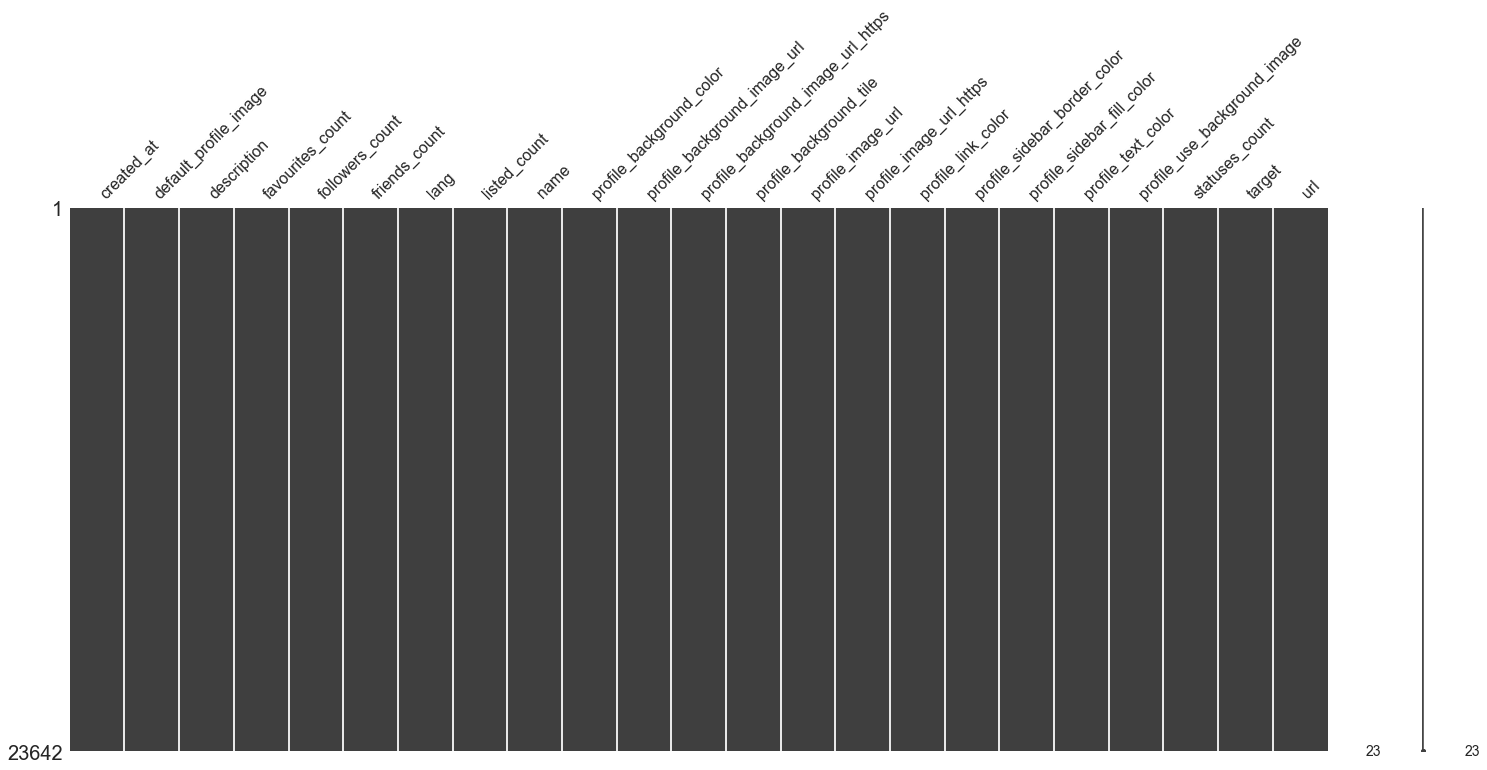

In [115]:
msno.matrix(users)

In [116]:
users.describe()

,default_profile_image,description,favourites_count,followers_count,friends_count,listed_count,profile_background_image_url,profile_background_image_url_https,profile_background_tile,profile_image_url,profile_image_url_https,profile_use_background_image,statuses_count,target,url
count,23642.000000,23642.000000,23642.000000,2.364200e+04,23642.000000,23642.000000,23642.000000,23642.000000,23642.000000,23642.000000,23642.000000,23642.000000,2.364200e+04,23642.000000,23642.000000
mean,0.035149,52.709246,6308.154513,7.009102e+03,1142.093055,39.696430,0.788427,0.788427,0.249387,0.999873,0.999873,0.948566,1.172010e+04,1.780433,0.264910
std,0.184161,50.951675,27062.258411,3.768324e+05,4787.216932,959.402774,0.408432,0.408432,0.432667,0.011264,0.011264,0.220886,4.305703e+04,1.435753,0.441295
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000e+01,149.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.000000e+01,0.000000,0.000000
50%,0.000000,44.000000,108.000000,3.400000e+01,221.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,9.200000e+01,2.000000,0.000000
75%,0.000000,82.000000,533.000000,2.110000e+02,642.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,3.508000e+03,3.000000,1.000000
max,1.000000,175.000000,913239.000000,5.254102e+07,191706.000000,89208.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.418488e+06,4.000000,1.000000


In [117]:
users.describe(exclude=[np.number])

,created_at,lang,name,profile_background_color,profile_link_color,profile_sidebar_border_color,profile_sidebar_fill_color,profile_text_color
count,23642,23642,23642,23642,23642,23642,23642,23642
unique,22743,46,21913,862,1373,415,645,686
top,2018-06-06 18:25:24,en,.,C0DEED,1DA1F2,C0DEED,DDEEF6,333333
freq,4,17992,9,13616,11969,15278,19257,20603


### Create model

### Drop non numeric features

In [118]:
users = users.drop(columns=['created_at', 'lang', 'name', 'profile_background_color', 'profile_image_url', 'profile_image_url_https', 'profile_link_color', 'profile_sidebar_border_color', 'profile_sidebar_fill_color', 'profile_text_color'], axis=1)

In [119]:
users.describe()

,default_profile_image,description,favourites_count,followers_count,friends_count,listed_count,profile_background_image_url,profile_background_image_url_https,profile_background_tile,profile_use_background_image,statuses_count,target,url
count,23642.000000,23642.000000,23642.000000,2.364200e+04,23642.000000,23642.000000,23642.000000,23642.000000,23642.000000,23642.000000,2.364200e+04,23642.000000,23642.000000
mean,0.035149,52.709246,6308.154513,7.009102e+03,1142.093055,39.696430,0.788427,0.788427,0.249387,0.948566,1.172010e+04,1.780433,0.264910
std,0.184161,50.951675,27062.258411,3.768324e+05,4787.216932,959.402774,0.408432,0.408432,0.432667,0.220886,4.305703e+04,1.435753,0.441295
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000e+01,149.000000,0.000000,1.000000,1.000000,0.000000,1.000000,2.000000e+01,0.000000,0.000000
50%,0.000000,44.000000,108.000000,3.400000e+01,221.000000,0.000000,1.000000,1.000000,0.000000,1.000000,9.200000e+01,2.000000,0.000000
75%,0.000000,82.000000,533.000000,2.110000e+02,642.000000,1.000000,1.000000,1.000000,0.000000,1.000000,3.508000e+03,3.000000,1.000000
max,1.000000,175.000000,913239.000000,5.254102e+07,191706.000000,89208.000000,1.000000,1.000000,1.000000,1.000000,1.418488e+06,4.000000,1.000000


In [120]:
users.to_csv('data/full/baseline_dataset.csv')

In [121]:
target = 'target'
features = users.columns[users.columns!=target]

In [122]:
X = users[features]
y = users[target]

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [124]:
# Fitting Random Forest Classification to the Training set
forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [125]:
# Fitting Logistic Regression
logreg = linear_model.LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Holdout score - forest

In [126]:
# Predicting the Test set results
y_pred = forest.predict(X_test)
# Making the Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual Target'], colnames=['Predicted Target']))

Predicted Target     0    1     2     3    4
Actual Target                               
0                 1654   16    10     4   61
1                   22  716     6     2   67
2                    4   15  1165     3   22
3                    4    0    15  1237    3
4                   73   80    19     4  709


### Most important features

In [127]:
sorted(zip(map(lambda x: round(x, 2), forest.feature_importances_), X.columns), reverse=True)[:10]

[(0.37, 'favourites_count'),
 (0.16, 'statuses_count'),
 (0.13, 'followers_count'),
 (0.089999999999999997, 'friends_count'),
 (0.059999999999999998, 'profile_background_tile'),
 (0.050000000000000003, 'url'),
 (0.050000000000000003, 'description'),
 (0.029999999999999999, 'profile_background_image_url_https'),
 (0.029999999999999999, 'listed_count'),
 (0.02, 'profile_background_image_url')]

### Holdout score - logistic regression

In [128]:
# Predicting the Test set results
y_pred = logreg.predict(X_test)
# Making the Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual Target'], colnames=['Predicted Target']))

Predicted Target     0    1     2     3    4
Actual Target                               
0                 1532    2   146    26   39
1                   65  621    58     1   68
2                    3    6  1190     2    8
3                    2    0    42  1215    0
4                  217  113   211     1  343


## KNN

In [129]:
scaler = MinMaxScaler()
X_train_n = scaler.fit_transform(X_train)
X_test_n = scaler.fit_transform(X_test)
X_n = scaler.fit_transform(X)

In [130]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_n, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [131]:
# Predicting the Test set results
y_pred = knn.predict(X_test_n)
# Making the Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual Target'], colnames=['Predicted Target']))

Predicted Target     0    1     2    3    4
Actual Target                              
0                 1524   39    47   62   73
1                   37  691     7    4   74
2                   42   15  1042   22   88
3                  161    0    76  986   36
4                  114   92    88   74  517


## Cross Validation scores

In [132]:
from sklearn.model_selection import cross_val_score
forest = RandomForestClassifier(n_estimators = 6, criterion = 'entropy', random_state = 42)
logreg = linear_model.LogisticRegression()
knn = KNeighborsClassifier(n_neighbors=10)
svm = svm.SVC()
scores = []
scores.append(cross_val_score(forest, X, y, cv=10, scoring='f1_macro').mean())
scores.append(cross_val_score(logreg, X, y, cv=10, scoring='f1_macro').mean())
scores.append(cross_val_score(knn, X_n, y, cv=10, scoring='f1_macro').mean())
scores.append(cross_val_score(svm, X, y, cv=10, scoring='f1_macro').mean())

In [133]:
# Random forest  /  Logistic Regression  /  KNN  /  SVM
scores

[0.89861153564482055,
 0.78611908974281697,
 0.7869300353494777,
 0.31990995070108746]

## Test BotOrNot

In [134]:
len(users[users.target==0])

6919

In [135]:
chosen_idx = np.random.choice(14052, replace=False, size=3800)
bots = users.iloc[chosen_idx]
bots['target'] = 0

In [136]:
genuines = users[users.target == 4]
genuines['target'] = 1

In [137]:
frames = [bots, genuines]
bot_or_not_df = pd.concat(frames, ignore_index=True)

In [138]:
target = 'target'
features = bot_or_not_df.columns[bot_or_not_df.columns!=target]
X = bot_or_not_df[features]
y = bot_or_not_df[target]

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [140]:
scaler = MinMaxScaler()
X_train_n = scaler.fit_transform(X_train)
X_test_n = scaler.fit_transform(X_test)
X_n = scaler.fit_transform(X)

In [141]:
from sklearn.model_selection import cross_val_score
forest = RandomForestClassifier(n_estimators = 6, criterion = 'entropy', random_state = 42)
logreg = linear_model.LogisticRegression()
knn = KNeighborsClassifier(n_neighbors=5)
scores = []
scores.append(cross_val_score(forest, X, y, cv=10, scoring='f1').mean())
scores.append(cross_val_score(logreg, X, y, cv=10, scoring='f1').mean())
scores.append(cross_val_score(knn, X_n, y, cv=10, scoring='f1').mean())

In [142]:
scores

[0.90298319319549447, 0.54638638974358855, 0.83811582441920274]

In [194]:
# Fitting Random Forest Classification to the Training set
forest = RandomForestClassifier(n_estimators = 1, criterion = 'entropy', random_state = 42)
forest.fit(X_train, y_train)
# Predicting the Test set results
y_pred = forest.predict(X_test)
# Making the Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual Target'], colnames=['Predicted Target']))

Predicted Target    0    1
Actual Target             
0                 884   88
1                  99  748


In [143]:
bots.describe()

,default_profile_image,description,favourites_count,followers_count,friends_count,listed_count,profile_background_image_url,profile_background_image_url_https,profile_background_tile,profile_use_background_image,statuses_count,target,url
count,3800.000000,3800.000000,3800.000000,3.800000e+03,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.0,3800.000000
mean,0.038684,62.814211,9772.864211,5.958372e+03,1580.338421,50.326316,0.863158,0.863158,0.303421,0.951316,14989.221316,0.0,0.307632
std,0.192867,47.984508,36332.448677,1.878057e+05,6086.143673,1252.536219,0.343726,0.343726,0.459796,0.215235,50830.043909,0.0,0.461574
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.000000,35.000000,7.000000,1.700000e+01,84.000000,0.000000,1.000000,1.000000,0.000000,1.000000,47.000000,0.0,0.000000
50%,0.000000,54.000000,195.000000,3.600000e+01,187.000000,0.000000,1.000000,1.000000,0.000000,1.000000,107.000000,0.0,0.000000
75%,0.000000,91.000000,630.250000,1.750000e+02,763.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3706.000000,0.0,1.000000
max,1.000000,164.000000,913239.000000,1.142709e+07,191706.000000,74384.000000,1.000000,1.000000,1.000000,1.000000,965547.000000,0.0,1.000000


In [144]:
genuines.describe()

,default_profile_image,description,favourites_count,followers_count,friends_count,listed_count,profile_background_image_url,profile_background_image_url_https,profile_background_tile,profile_use_background_image,statuses_count,target,url
count,3474.000000,3474.000000,3474.000000,3474.000000,3474.000000,3474.000000,3474.0,3474.0,3474.000000,3474.000000,3474.000000,3474.0,3474.000000
mean,0.003742,63.778066,4669.620322,1393.219632,633.242372,19.496546,1.0,1.0,0.376223,0.887737,16958.220207,1.0,0.364421
std,0.061067,50.882751,11527.566663,17216.664524,1600.962972,157.740969,0.0,0.0,0.484507,0.315735,30696.286104,0.0,0.481337
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.0,1.0,0.000000,0.000000,3.000000,1.0,0.000000
25%,0.000000,20.000000,261.250000,149.000000,169.000000,0.000000,1.0,1.0,0.000000,1.000000,1810.250000,1.0,0.000000
50%,0.000000,51.000000,1286.000000,341.000000,319.000000,2.000000,1.0,1.0,0.000000,1.000000,6609.000000,1.0,0.000000
75%,0.000000,106.750000,4727.000000,803.750000,635.750000,8.000000,1.0,1.0,1.000000,1.000000,19467.000000,1.0,1.000000
max,1.000000,160.000000,313954.000000,986837.000000,46310.000000,6166.000000,1.0,1.0,1.000000,1.000000,399555.000000,1.0,1.000000
